In [427]:
import numpy as np
from PIL import Image
import matplotlib as plt

In [428]:
def load_and_scale_images(image_path, watermark_path):
    image = Image.open(image_path).convert('L')  
    image = image.resize((512, 512))
    
    image_array = np.array(image)
    
    watermark = Image.open(watermark_path).convert('L')
    watermark = watermark.resize((32, 32))
    watermark_array = np.array(watermark) > 128
    watermark = Image.fromarray(watermark_array)
    
    return image_array, watermark_array, image, watermark

In [429]:
image_array,watermark_array,input_image, watermark_image=load_and_scale_images('lena.png','watermark_image.webp')

In [430]:
def shuffle_watermark_image(watermark_image):
    np.random.seed(42)

    wm_img_array = np.array(watermark_image) 
    shape = wm_img_array.shape

    wm_img_array = wm_img_array.flatten()

    indices = np.arange(wm_img_array.size)
    i_n = np.random.permutation(indices)

    shuffled_img_array = wm_img_array[i_n]

    shuffled_image_array = shuffled_img_array.reshape(shape)
    shuffled_image = Image.fromarray(shuffled_image_array)

    return shuffled_image, i_n

In [431]:
shuffled_watermark, indices = shuffle_watermark_image(watermark_image)

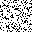

In [432]:
shuffled_watermark

In [433]:
np.array(shuffled_watermark)

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True, False,  True, ..., False,  True, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False,  True]])

In [434]:
def split_image_into_four(image):

    width, height = image.size

    mid_width = width // 2
    mid_height = height // 2

    ftl = image.crop((0, 0, mid_width, mid_height))  
    ftr = image.crop((mid_width, 0, width, mid_height))  
    fbl = image.crop((0, mid_height, mid_width, height)) 
    fbr = image.crop((mid_width, mid_height, width, height))

    return ftl, ftr, fbl, fbr

In [435]:
def merge_image_from_four(ftl, ftr, fbl, fbr):
    width, height = ftl.size
    
    merged_image = Image.new('L', (width * 2, height * 2))

    merged_image.paste(ftl, (0, 0))  
    merged_image.paste(ftr, (width, 0)) 
    merged_image.paste(fbl, (0, height))  
    merged_image.paste(fbr, (width, height))

    return merged_image

In [436]:
import bisect

def find_interval(sorted_array, x):
    index = bisect.bisect_right(sorted_array, x)
    return index

In [437]:
def reconstruct_image(blocks, original_indices, block_size):
    reconstruct_image = np.zeros((512 // 2, 512 // 2))
    for (U, D, Vt), (i,j) in zip(blocks, original_indices):
        #print(D[0])
        D_matrix = np.diag(D)
        r_b = np.dot(U, np.dot(D_matrix, Vt))
        reconstruct_image[i:i+block_size,j: j+block_size] = r_b
    return reconstruct_image

In [438]:
d_large = []
d_new = []
blocks = []
def watermark_embedding_in_d_matrix(ftl, wm, block_size=8):
    global d_large, d_new, blocks
    original_indices = []
    wm_array = np.array(wm) 
    wm_array = wm_array.flatten().astype('uint64')
    ftl_arr = np.array(ftl)
    #d_large = []
    #blocks = []
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            d_large.append(D[0])
            original_indices.append((i,j))
            blocks.append((U, D, V))

    T=60
    d_max = max(d_large)
    d_min = min(d_large)
    ds = np.linspace(d_min-T, d_max + T)

    #print(d_low)
    #print(d_high)
    bit_idx = 0
    for d in d_large:
        idx = find_interval(ds, d)
        dlow = ds[idx-1]
        dhigh = ds[idx]
        #print(f'Watermark bit {wm_array[bit_idx]}')
        #print(f'Donja granica {dlow}')
        #print(f'Gornja granica {dhigh}')
        #print(f'Singularna vrednosti{d}')
        
        if wm_array[bit_idx] == 1:
            blocks[bit_idx][1][0] = (dlow + (dhigh + dlow)/2)/2
            #print('if')
        else:
            blocks[bit_idx][1][0] = (dhigh + (dhigh + dlow)/2)/2
            #print('else')
        d_new.append(blocks[bit_idx][1][0])
        bit_idx += 1
        #print('-------------------')

    result = reconstruct_image(blocks, original_indices, 8)
    return result

In [439]:
def watermark_embedding_in_u_matrix(fbr, wm, block_size=8, alpha=0.0):
    fbr_arr = np.array(fbr)
    wm_array = np.array(wm).flatten().astype('uint64')

    original_indices = []
    blocks = []
    
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, V = np.linalg.svd(block)
            original_indices.append((i,j))
            blocks.append((U, D, V))

    bit_idx = 0
    for U, D, V in blocks:
        u_diff = abs(U[0, 0]) - abs(U[1, 0])
        
        if (wm_array[bit_idx] == 1 and u_diff > alpha) or (wm_array[bit_idx]==0 and u_diff<alpha):
            #print('1')
            U[1,0]=-abs(abs(U[1,0])-(alpha-u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha-u_diff)/2)
        elif (wm_array[bit_idx] == 1 and u_diff < alpha) or (wm_array[bit_idx]==0 and u_diff>alpha):
            U[1,0]=-abs(abs(U[1,0])-(alpha+u_diff)/2)
            U[0,0]=-abs(abs(U[0,0])+(alpha+u_diff)/2)
            #print('2')
        bit_idx += 1

    reconstructed_fbr = reconstruct_image(blocks, original_indices, block_size)
    return reconstructed_fbr

In [440]:
def watermak_embedding(image, wm):
    ftl, ftr, fbl, fbr = split_image_into_four(input_image)
    
    ftl_new = watermark_embedding_in_d_matrix(ftl, wm)
    ftl_new = Image.fromarray(ftl_new)
    ftl_new.show()
    
    fbr_new = watermark_embedding_in_u_matrix(fbr, wm)
    fbr_new = Image.fromarray(fbr_new)
    fbr_new.show()
    
    merged_image = merge_image_from_four(ftl_new, ftr, fbl, fbr_new)
    merged_image.show()
    merged_image.save('watermarked_image.png')
    
    return merged_image

In [441]:
#ftl, ftr, fbl, fbr = split_image_into_four(input_image)

In [442]:
watermarked_image = watermak_embedding(input_image, watermark_image)

In [443]:
ftl_new, _, _, fbr_new = split_image_into_four(watermarked_image)

In [444]:
#np.array(ftl_new) == np.array(ftl)

In [445]:
#min(d_large)

In [446]:
#max(d_large)

In [447]:
#T=60
#d_max = max(d_large)
#d_min = min(d_large)
#ds = np.linspace(d_min-T, d_max + T)

In [448]:
#d_new

In [449]:
#d_large

In [450]:
def extract_watermark_from_d_matrix(ftl, watermark_size=(32, 32), block_size=8):
    
    ftl_arr = np.array(ftl)

    extraxted_watermark = []
    
    for i in range(0, ftl_arr.shape[0], block_size):
        for j in range(0, ftl_arr.shape[1], block_size):
            block = ftl_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)

            d = D[0]
            #print(d)
            idx = find_interval(ds, d)
            dh = ds[idx]
            dl = ds[idx-1]
            #print(f'dhigh {dh}')
            #print(f'dlow {dl}')
            #print('-----------')

            if  d < ((dl+dh)/2):
                extraxted_watermark.append(1)
                #print('if')
            else:
                extraxted_watermark.append(0)
                #print('else')
    extraxted_watermark_result = np.array(extraxted_watermark).reshape((32,32))
    return extraxted_watermark_result

In [451]:
res = extract_watermark_from_d_matrix(ftl_new)

In [452]:
res

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [453]:
res2 = Image.fromarray(res.astype(np.uint8)*255)

In [454]:
res2.show()

In [460]:
def extract_watermark_from_u_matrix(fbr, watermark_size=(32, 32), block_size=8):
    fbr_arr = np.array(fbr)
    extracted_watermark = []
    
    for i in range(0, fbr_arr.shape[0], block_size):
        for j in range(0, fbr_arr.shape[1], block_size):
            block = fbr_arr[i:i+block_size, j:j+block_size]
            U, D, Vt = np.linalg.svd(block)

            if abs(U[0,0])>abs(U[1,0]):
                extracted_watermark.append(0)
            else:
                extracted_watermark.append(1)
    
    extracted_watermark = np.array(extracted_watermark).reshape(watermark_size)
    return extracted_watermark


In [461]:
watermark2_fbr = extract_watermark_from_u_matrix(fbr_new)

In [462]:
watermark2_fbr

array([[0, 0, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [463]:
watermark2_extracted = Image.fromarray(watermark2_fbr.astype(np.uint8)*255)

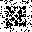

In [465]:
watermark2_extracted